<a href="https://colab.research.google.com/github/phipi-a/tu-berlin-aal/blob/master/action_selector_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install spacy==2.3.5

In [ ]:
!unzip /content/drive/MyDrive/Studium/Datasets/hjalle.zip -d /content/datasetout

Archive:  /content/drive/MyDrive/Studium/Datasets/hjalle.zip
  inflating: /content/datasetout/x_data.npy  
  inflating: /content/datasetout/y_data.npy  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Input, MaxPooling1D, Flatten, Bidirectional, GRU, BatchNormalization ,SimpleRNN, RNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import losses
from tensorflow.keras import backend as K
import spacy
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import json

In [ ]:
from spacy.cli import download

try:
    nlp_german = spacy.load('de_core_news_lg')
except OSError:
    print('Downloading language model\n')
    from spacy.cli import download
    download('de_core_news_lg')
    nlp_german = spacy.load('de_core_news_lg')


In [ ]:
def listToIndexLookup(actions):
  ret = {}
  for idx, action in enumerate(actions):
    ret[action] =  idx
  return ret

In [ ]:
import sys

MAX_TEXT_LENGTH = 20
VECTOR_LENGTH = 300

FORBIDDEN_POS = ["PUNCT", "SYM", "NUM", "SPACE", "DET"]
POS = [
  "ADJ",
  "ADP",
  "ADV", 
  "AUX", 
  "CONJ", 
  "CCONJ", 
  "DET", 
  "INTJ", 
  "NOUN", 
  "NUM", 
  "PART", 
  "PRON", 
  "PROPN",
  "SCONJ",
  "VERB",
  "X",
  "SPACE"
]
POS_LOOKUP = listToIndexLookup(POS)
POS_LENGTH = len(POS)

DEVICES = ["coffee machine", "oven", "other"]
DEVICE_LOOKUP = listToIndexLookup(DEVICES)
DEVICES_LENGTH = len(DEVICES)

ACTIONS = [
  'latte macchiato',
  'hot milk', 
  'foam milk', 
  'tea & hot water', 
  'espresso', 
  'grill', 
  'machine care', 
  'cold milk', 
  'bread baking program', 
  'upper and lower heating', 
  'pizza program', 
  'coffee', 
  'upper heating', 
  'preheat', 
  'lower heating', 
  'air circulation',
  'keepwarm',
  'humiditycontrol'
]
ACTIONS_LOOKUP = listToIndexLookup(ACTIONS)
ACTIONS_LENGTH = len(ACTIONS)

LENGTH = VECTOR_LENGTH + POS_LENGTH + DEVICES_LENGTH

def getClassWeights(y):
  ret = {}
  for action in ACTIONS:
    i = ACTIONS_LOOKUP[action]
    ret[i] = 1 - (np.count_nonzero(y == i) / len(y))
  return ret


In [ ]:
def processSample(sample):
    doc = nlp_german(sample["text"])
    device = DEVICE_LOOKUP[sample["device"]]

    if len(doc) > MAX_TEXT_LENGTH:
        return False, None, None

    sample_x = np.empty(shape=[0, LENGTH])
    for tag in doc:
        if tag.pos_ in FORBIDDEN_POS:
            continue
            
        lemma_tag = nlp_german(tag.lemma_.lower())[0]

        pos = to_categorical(POS_LOOKUP[tag.pos_], POS_LENGTH)
        dev = to_categorical(device, DEVICES_LENGTH)

        t = np.concatenate([lemma_tag.vector, pos, dev])
        sample_x = np.append(sample_x, [t], axis=0)

    # fill up rest
    while len(sample_x) < MAX_TEXT_LENGTH:
        sample_x = np.append(sample_x, [np.zeros(LENGTH)], axis=0)

    return True, sample_x, ACTIONS_LOOKUP[sample["action"]]


def loadData2(path):
    with open(path) as f:
        data = json.load(f)

        x = np.empty(shape=[0, MAX_TEXT_LENGTH, LENGTH])
        y = np.empty(shape=[0])
        laenge = len(data)
        for idx, sample in enumerate(data):
            shouldAdd, sample_x, sample_y = processSample(sample)

            if shouldAdd:
                x = np.append(x, [sample_x], axis=0)
                y = np.append(y, [sample_y], axis=0)

            sys.stdout.write("\r" + "Loaded: " + str(idx) + "/" + str(laenge))
            sys.stdout.flush()

        return x, y


#data_x, data_y = loadData2("/content/out2.json")

#with open('x_data_20_without_det.npy', 'wb') as f:
#    np.save(f, data_x)
#with open('y_data_20_without_det.npy', 'wb') as f:
#    np.save(f, data_y)

In [ ]:
data_x = np.load("/content/datasetout/x_data.npy")
data_y = np.load("/content/datasetout/y_data.npy")

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 20, 40)            41040     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 18)                738       
Total params: 51,538
Trainable params: 51,538
Non-trainable params: 0
_________________________________________________________________


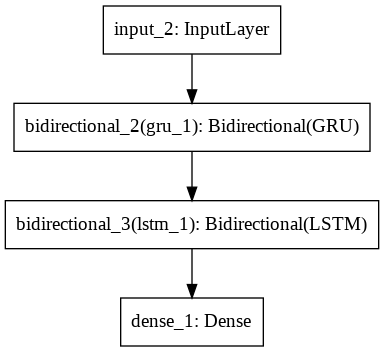

In [ ]:
model = Sequential()
model.add(Input(shape=(MAX_TEXT_LENGTH, LENGTH)))
model.add(Bidirectional(GRU(20,return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(20,dropout=0.2)))
model.add(Dense(ACTIONS_LENGTH, activation="softmax"))
model.build()
model.compile(
    optimizer=Adam(),
    loss=losses.categorical_crossentropy,metrics=['accuracy'])
 
model.summary()
plot_model(model)

In [ ]:
# your class labels

class AccuracyCallback(tf.keras.callbacks.Callback):

    def __init__(self, test_data):
        self.classes = ACTIONS
        self.test_data = test_data
        self.class_history = list()
        for i in self.classes:
           self.class_history.append(list())

    def on_epoch_end(self, epoch, logs=None):
        x_data, y_data = self.test_data

        correct = 0
        incorrect = 0

        x_result = self.model.predict(x_data, verbose=0)

        x_numpy = []

        class_correct = [0] * len(self.classes)
        class_incorrect = [0] * len(self.classes)

        for i in range(len(x_data)):
            x = x_data[i]
            y = y_data[i]

            res = x_result[i]

            actual_label = np.argmax(y)
            pred_label = np.argmax(res)

            if(pred_label == actual_label):
                x_numpy.append(["cor:", str(y), str(res), str(pred_label)])     
                class_correct[actual_label] += 1   
                correct += 1
            else:
                x_numpy.append(["inc:", str(y), str(res), str(pred_label)])
                class_incorrect[actual_label] += 1
                incorrect += 1

        print("\tCorrect: %d" %(correct))
        print("\tIncorrect: %d" %(incorrect))

        for i in range(len(self.classes)):
            tot = float(class_correct[i] + class_incorrect[i])
            class_acc = -1
            if (tot > 0):
                class_acc = float(class_correct[i]) / tot
            self.class_history[i].append(class_acc)
            print("\t%s: %.3f" %(self.classes[i], class_acc)) 

        acc = float(correct) / float(correct + incorrect)  

        print("\tCurrent Network Accuracy: %.3f" %(acc))

In [ ]:
#class_weights = class_weight.compute_class_weight('balanced',
#                                                 range(ACTIONS_LENGTH),
#                                                 Y_train)
#class_weights_dict = {}
#for idx, w in enumerate(class_weights):
#  class_weights_dict[idx] = w

class_weights = getClassWeights(Y_train)
y_train_cat = to_categorical(Y_train, ACTIONS_LENGTH)  
y_test_cat = to_categorical(Y_test, ACTIONS_LENGTH)
val_data = (X_test, y_test_cat)

accuracy_callback = AccuracyCallback(val_data)

history=model.fit(
    callbacks=[accuracy_callback],
    x=X_train,
    y=y_train_cat,
    batch_size=512,
    epochs=100,
    shuffle=True,
    class_weight=class_weights,
    validation_data=val_data)

Epoch 1/100
56/56 [==============================] - 21s 259ms/step - loss: 2.2341 - accuracy: 0.3080 - val_loss: 1.2785 - val_accuracy: 0.6870
	Correct: 6482
	Incorrect: 2953
	latte macchiato: 0.922
	hot milk: 0.005
	foam milk: 0.000
	tea & hot water: 0.958
	espresso: 0.000
	grill: 0.972
	machine care: 0.446
	cold milk: 0.993
	bread baking program: 0.000
	upper and lower heating: 0.000
	pizza program: 0.000
	coffee: 0.997
	upper heating: 0.911
	preheat: 0.000
	lower heating: 0.363
	air circulation: 0.582
	keepwarm: 0.000
	humiditycontrol: 0.000
	Current Network Accuracy: 0.687
Epoch 2/100
56/56 [==============================] - 13s 234ms/step - loss: 0.9957 - accuracy: 0.7272 - val_loss: 0.5035 - val_accuracy: 0.8795
	Correct: 8298
	Incorrect: 1137
	latte macchiato: 1.000
	hot milk: 0.940
	foam milk: 0.739
	tea & hot water: 0.998
	espresso: 0.992
	grill: 0.915
	machine care: 0.976
	cold milk: 1.000
	bread baking program: 0.000
	upper and lower heating: 0.831
	pizza program: 0.000
	co

In [ ]:
nlp_german("reinige")[0].has_vector

True

In [ ]:
_, sequence, _ = processSample({
    "text": "reinige dich",
    "device": "oven",
    "action": "espresso"
})

prediction=model.predict(sequence.reshape((1,MAX_TEXT_LENGTH,LENGTH)))[0]

print("predicted: ", ACTIONS[np.argmax(prediction)]," | ", np.round(np.max(prediction),4))
prediction

predicted:  machine care  |  0.9995


array([1.0257446e-05, 5.1080457e-07, 6.7467081e-06, 1.5384363e-07,
       2.1449729e-05, 4.5246511e-06, 9.9953198e-01, 5.9266972e-07,
       3.4676489e-04, 1.8365208e-08, 2.7231908e-06, 4.4416265e-05,
       4.5539366e-08, 6.8668851e-07, 3.9186248e-06, 1.5831733e-05,
       6.1279417e-07, 8.7616427e-06], dtype=float32)

In [ ]:
def plot(history):
  fig, axs = plt.subplots(len(history)-len([ v for k,v in history.items() if 'val' in k]))
  z=0
  for k in range(len(history)):
      key=list(history.keys())[k]
      if not "val_" in key:
        axs[z].plot(history[key], label=key)
        axs[z].legend(bbox_to_anchor=(1, 1), loc='upper left',)
        if "val_"+key in history:
          axs[z].plot(history["val_"+key], label="val_"+key)
          axs[z].legend(bbox_to_anchor=(1, 1), loc='upper left',)
        z=z+1

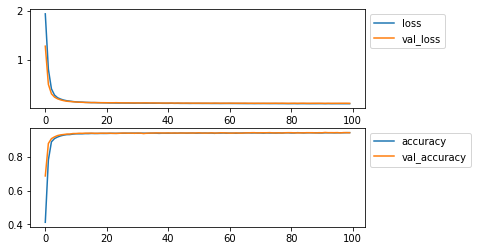

In [ ]:
#z = {}
#for idx, action in enumerate(ACTIONS):
#  z[action] = accuracy_callback.class_history[idx]

history_big = dict(history.history)
#history_big.update(z)
plot(history_big)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model_weights=model.get_weights()
np.save('model_weights.npy', model_weights)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
doc = nlp_german(str("lauf"))
lemmas
for token in doc:
  if not (token.pos_=="PUNCT" or token.pos_=="SYM" or token.pos_=="NUM"):
    lemmas = nlp_german.vocab.vectors[token.lemma]
print(lemmas)

KeyError: ignored

In [ ]:
for vector in nlp_german.vocab.vectors.values():
    print(vector)

In [ ]:
print("ich hoffe dass ich kein corona habe")

ich hoffe dass ich kein corona habe
